<a href="https://colab.research.google.com/github/VeerendarGoud/ML-Projects/blob/master/Rossmann_Store_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "veerendar2888" # username from the json file
os.environ['KAGGLE_KEY'] = "600e923d8c4f7b3a7241285ae4ed011f" # key from the json file
!kaggle competitions download -c rossmann-store-sales # api copied from kaggle


  0% 0.00/192k [00:00<?, ?B/s]
100% 192k/192k [00:00<00:00, 45.7MB/s]
  0% 0.00/44.0k [00:00<?, ?B/s]
100% 44.0k/44.0k [00:00<00:00, 27.6MB/s]
 75% 5.00M/6.71M [00:00<00:00, 8.37MB/s]
100% 6.71M/6.71M [00:00<00:00, 10.3MB/s]
  0% 0.00/310k [00:00<?, ?B/s]
100% 310k/310k [00:00<00:00, 64.0MB/s]


In [0]:
import warnings
warnings.filterwarnings('ignore')

# loading packges
# basics + dates

import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# prophet by facebook

from fbprophet import Prophet

# pd plt
pd.plotting.register_matplotlib_converters()

In [0]:
# train data
train = pd.read_csv('/content/train.csv.zip',parse_dates = True,index_col='Date')

# store data
store = pd.read_csv('/content/store.csv')


In [5]:
train.index[:10]

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [0]:
## index frequency check 'D'

In [7]:
# first glance at the train set: head and tail
print("In total: ",train.shape)

In total:  (1017209, 8)


In [8]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [0]:
##

In [0]:
# data extraction

train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable

train['SalePerCustomer'] = train['Sales']/train['Customers']


In [11]:
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

###### On average customers spend about 9.50$ per day. Though there are days with Sales equal to zero.

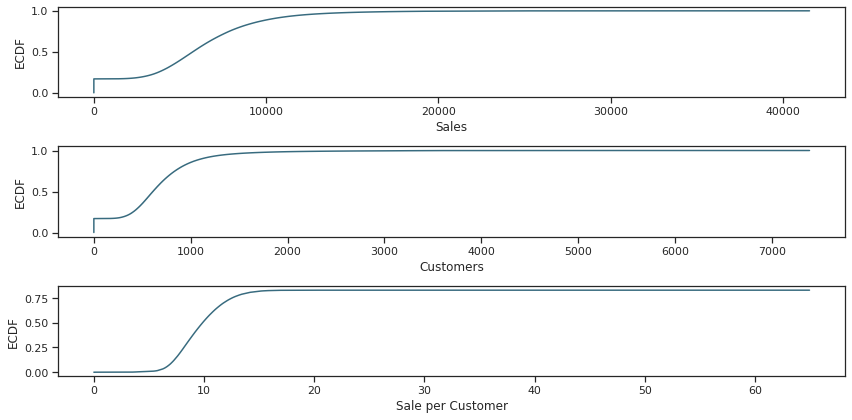

In [18]:
# Empirical Cumulative Distribution Function

sns.set(style='ticks') # to format into seaborn
c = '#386B7F'
plt.figure(figsize=(12,6))


plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x,cdf.y,label='statmodels',color=c)
plt.xlabel('Sales'); 
plt.ylabel('ECDF');


# Customers ecdf plot

plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x,cdf.y,label = 'statmodels',color = c)
plt.xlabel('Customers')
plt.ylabel('ECDF');

# Sale per Customer ecdf plot

plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x,cdf.y,label='statmodels',color=c)
plt.xlabel('Sale per Customer');
plt.ylabel('ECDF');
plt.tight_layout()

###### About 20% of data has zero amount of sales / customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000. So what about zero sales, is it only due to the fact that the store is closed?

In [34]:
# closed stores

train[(train.Open == 0) & (train.Sales == 0) ].shape


(172817, 13)

###### There're 172817 closed stores in the data. It is about 10% of the total amount of observations. To avoid any biased forecasts we will drop these values.

In [35]:
# open stores with 0 sales

train[(train.Open == 1) & (train.Sales == 0) ].shape

(54, 13)

In [37]:
print("Closed stores and days which didn't have nay sales won't be counted into the forecasts.")
train = train[(train['Open'] != 0) & (train['Sales'] != 0)]

print('In total:',train.shape)


Closed stores and days which didn't have nay sales won't be counted into the forecasts.
In total: (844338, 13)


In [38]:
# Store information

store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [39]:
# missing values 

store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [0]:
# We have few variables with missing values that we need to deal with.
# let's start with the CompetitionDistance.

In [42]:
store[store['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [0]:
# Apperently this information is simply missing from the data.
# No particular pattern observed.
# In this case, it makes a complete sense to replace NaN with median
# values (which is twice less than the average).

In [0]:
# fill NaN with a median value (skewed distribution)

store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(),
                                    inplace=True)

In [48]:
# Promo2sinceWeek
# no promo = no information about the promo?
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

No, if there's no Promo2 then there's no information about it. We can replace these values by zeros.The same goes for the variables
deducted from the competition,
CompetitionOpenSinceMonth and 
CompetitionOpensinceYear

In [0]:
# replace NA's by 0

store.fillna(0,inplace=True)

In [0]:
# Joining train set with an additional store information.
# by specifying inner join we make sure that only those observations
# that are present in both train and store sets are merged together.

train_store =  pd.merge(train,store,how='inner',on='Store')

In [50]:
train.shape,train_store.shape

((844338, 13), (844338, 22))

**Store types**<br>
In this section we will closely look at different levels of Storetype and how the main metric Sales is Distributed among them.

In [51]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


StoreType B has the highest average of Sale among all others, however we have much less data for it. So let's print an overall sum of the Sales and Customers to see which StoreType is the most selling and crowded one:

In [52]:
train_store.groupby('StoreType')['Customers','Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


Clearly stores of type A. StreTypeD gose on the second place in both Sales and Customers. What about date perionds? Seaborn's facet grid is the best tool for this task:


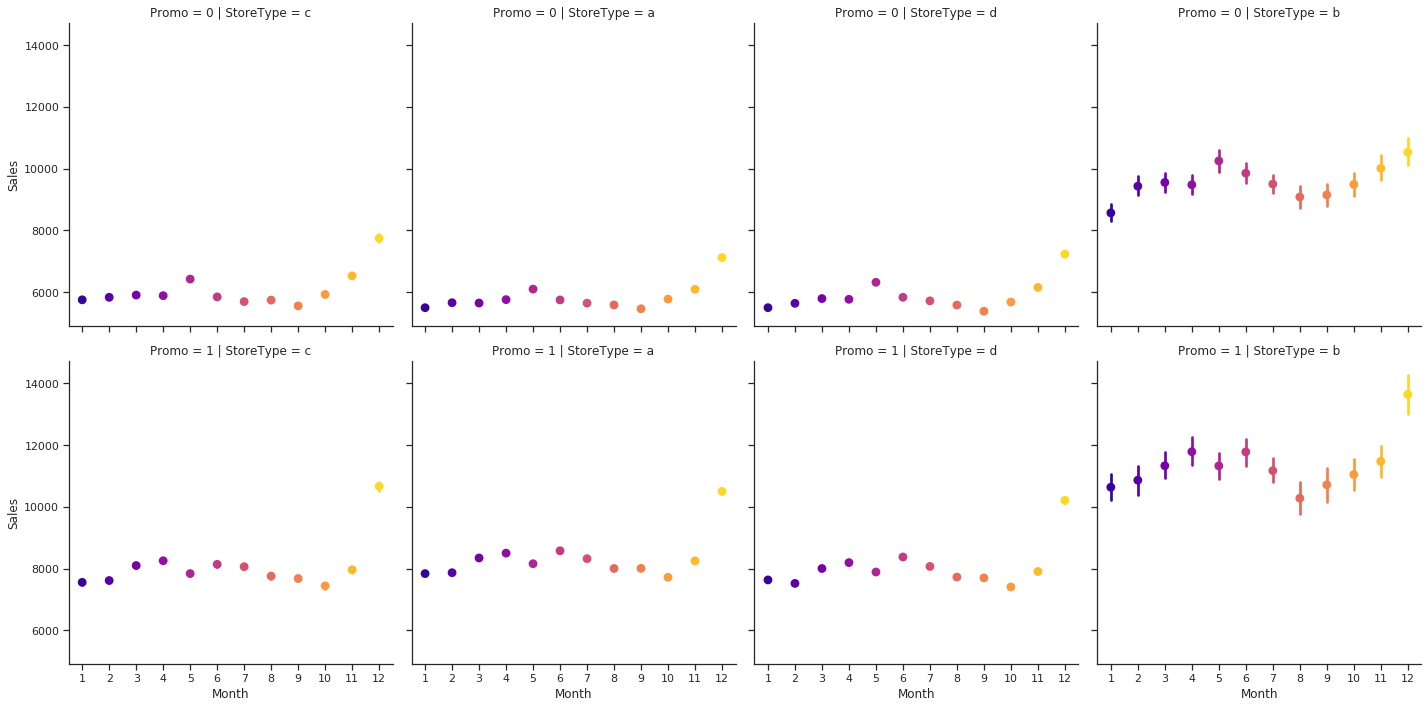

In [71]:
sns.set(style="ticks")
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               #hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

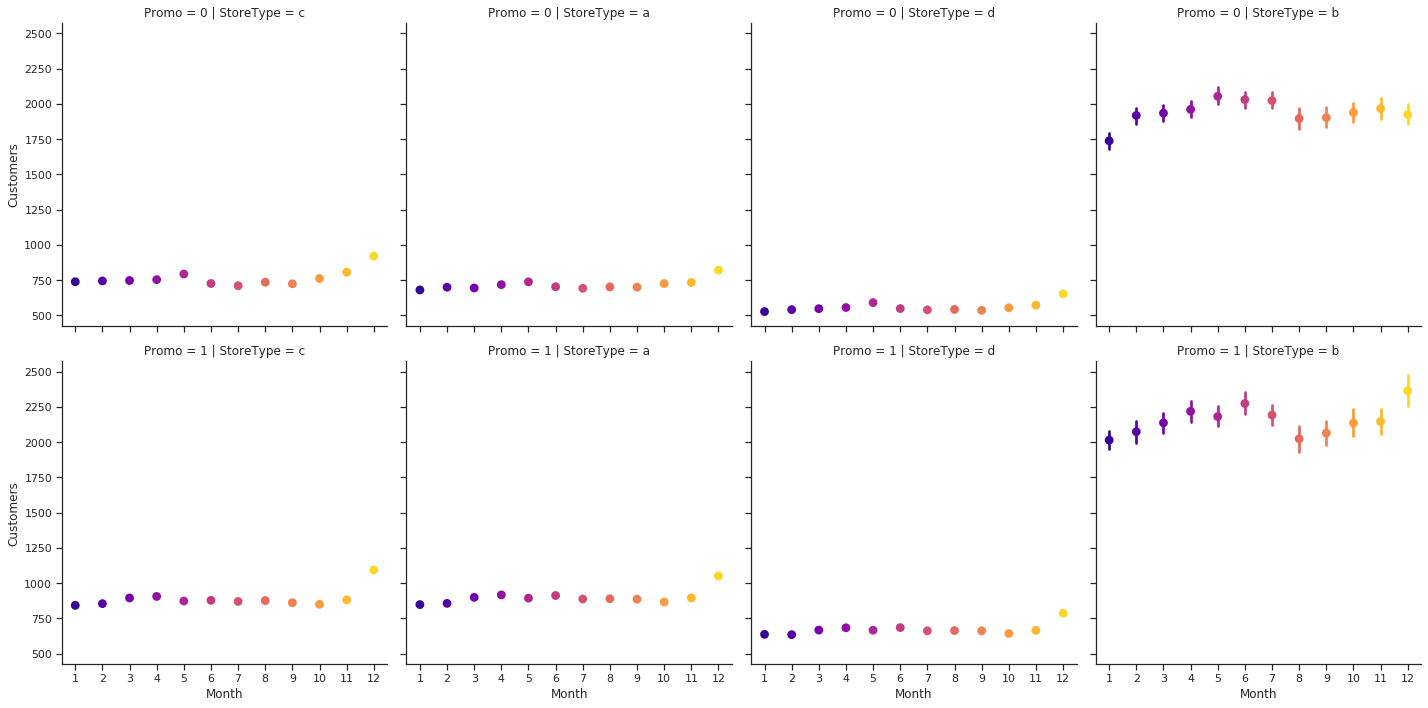

In [67]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
              # hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

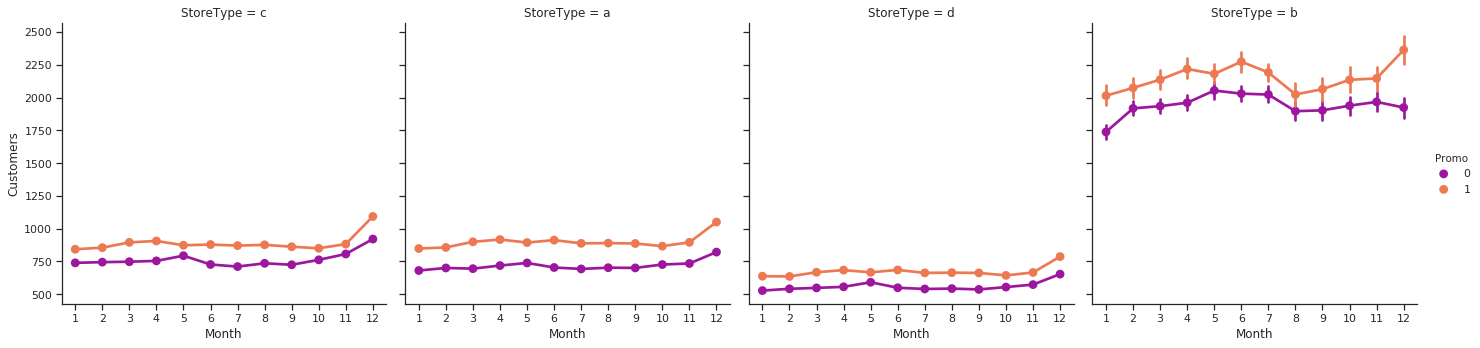

In [69]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'Promo',
              # row = 'Promo', # per promo in the store in rows
               color = c,
               legend = True) 

All store types follow the same trend but at different scales depending on the presence of the (first) promotion Prom and StoreType itself(case for B).

Already at this point, we can see that Sales escalate towards Christmas holidays. But we'll talk about seasonalities and trends later in the Time Series Analysis section.

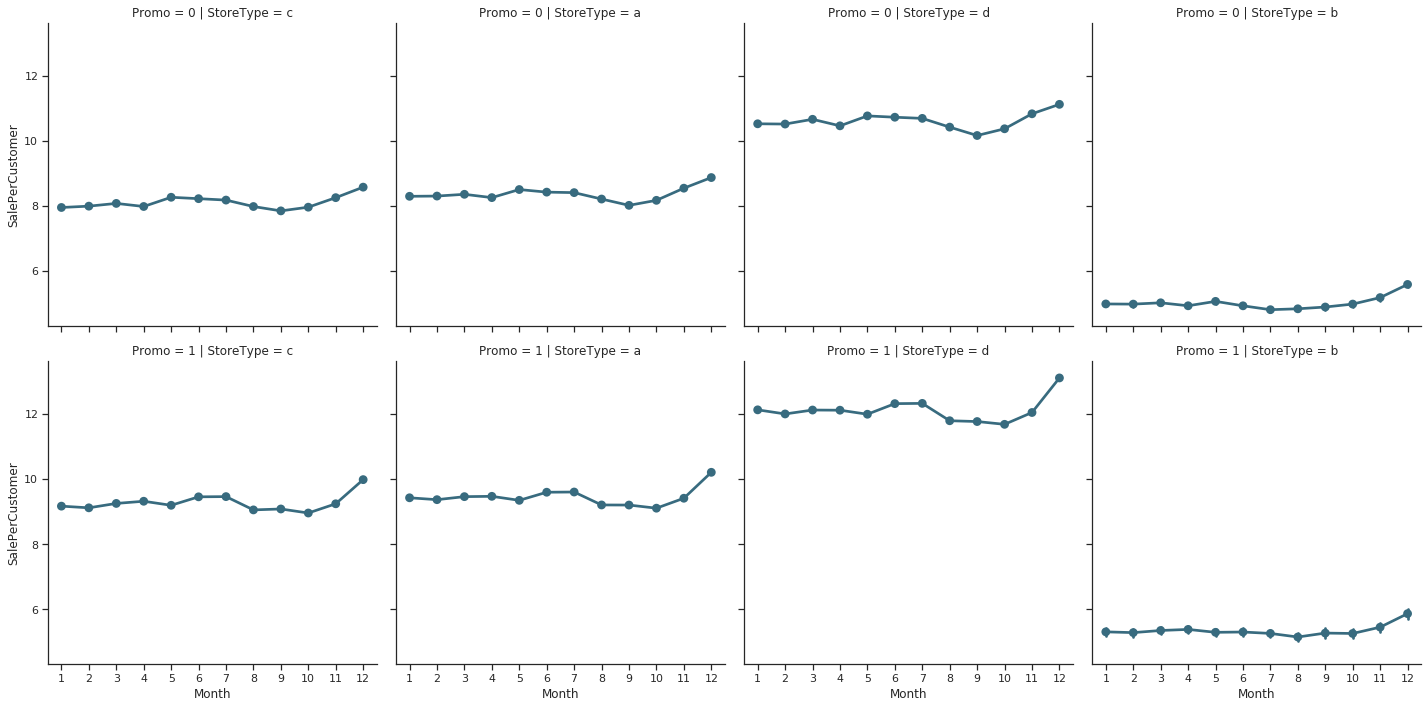

In [70]:
# sale per customer trends

sns.factorplot(data=train_store,x='Month',y='SalePerCustomer',
               col='StoreType',
               pallette='plasma',
               row='Promo',
               color=c)

Eventhough the plots above showed StoreType B as the most selling and performant one, in reality it is not true. The highest SalePerCustomer amount is observed at the StoreType D, about 12€ with Promo and 10€ without. As for StoreType A and C it is about 9€.

Low SalePerCustomer amount for StoreType B describes its Buyer Cart:
there are a lot of people who shop essentially for 'small' things (or in a little quantity).Plus we saw that overall this StoreType generated the least amount of sales and customers over the period.

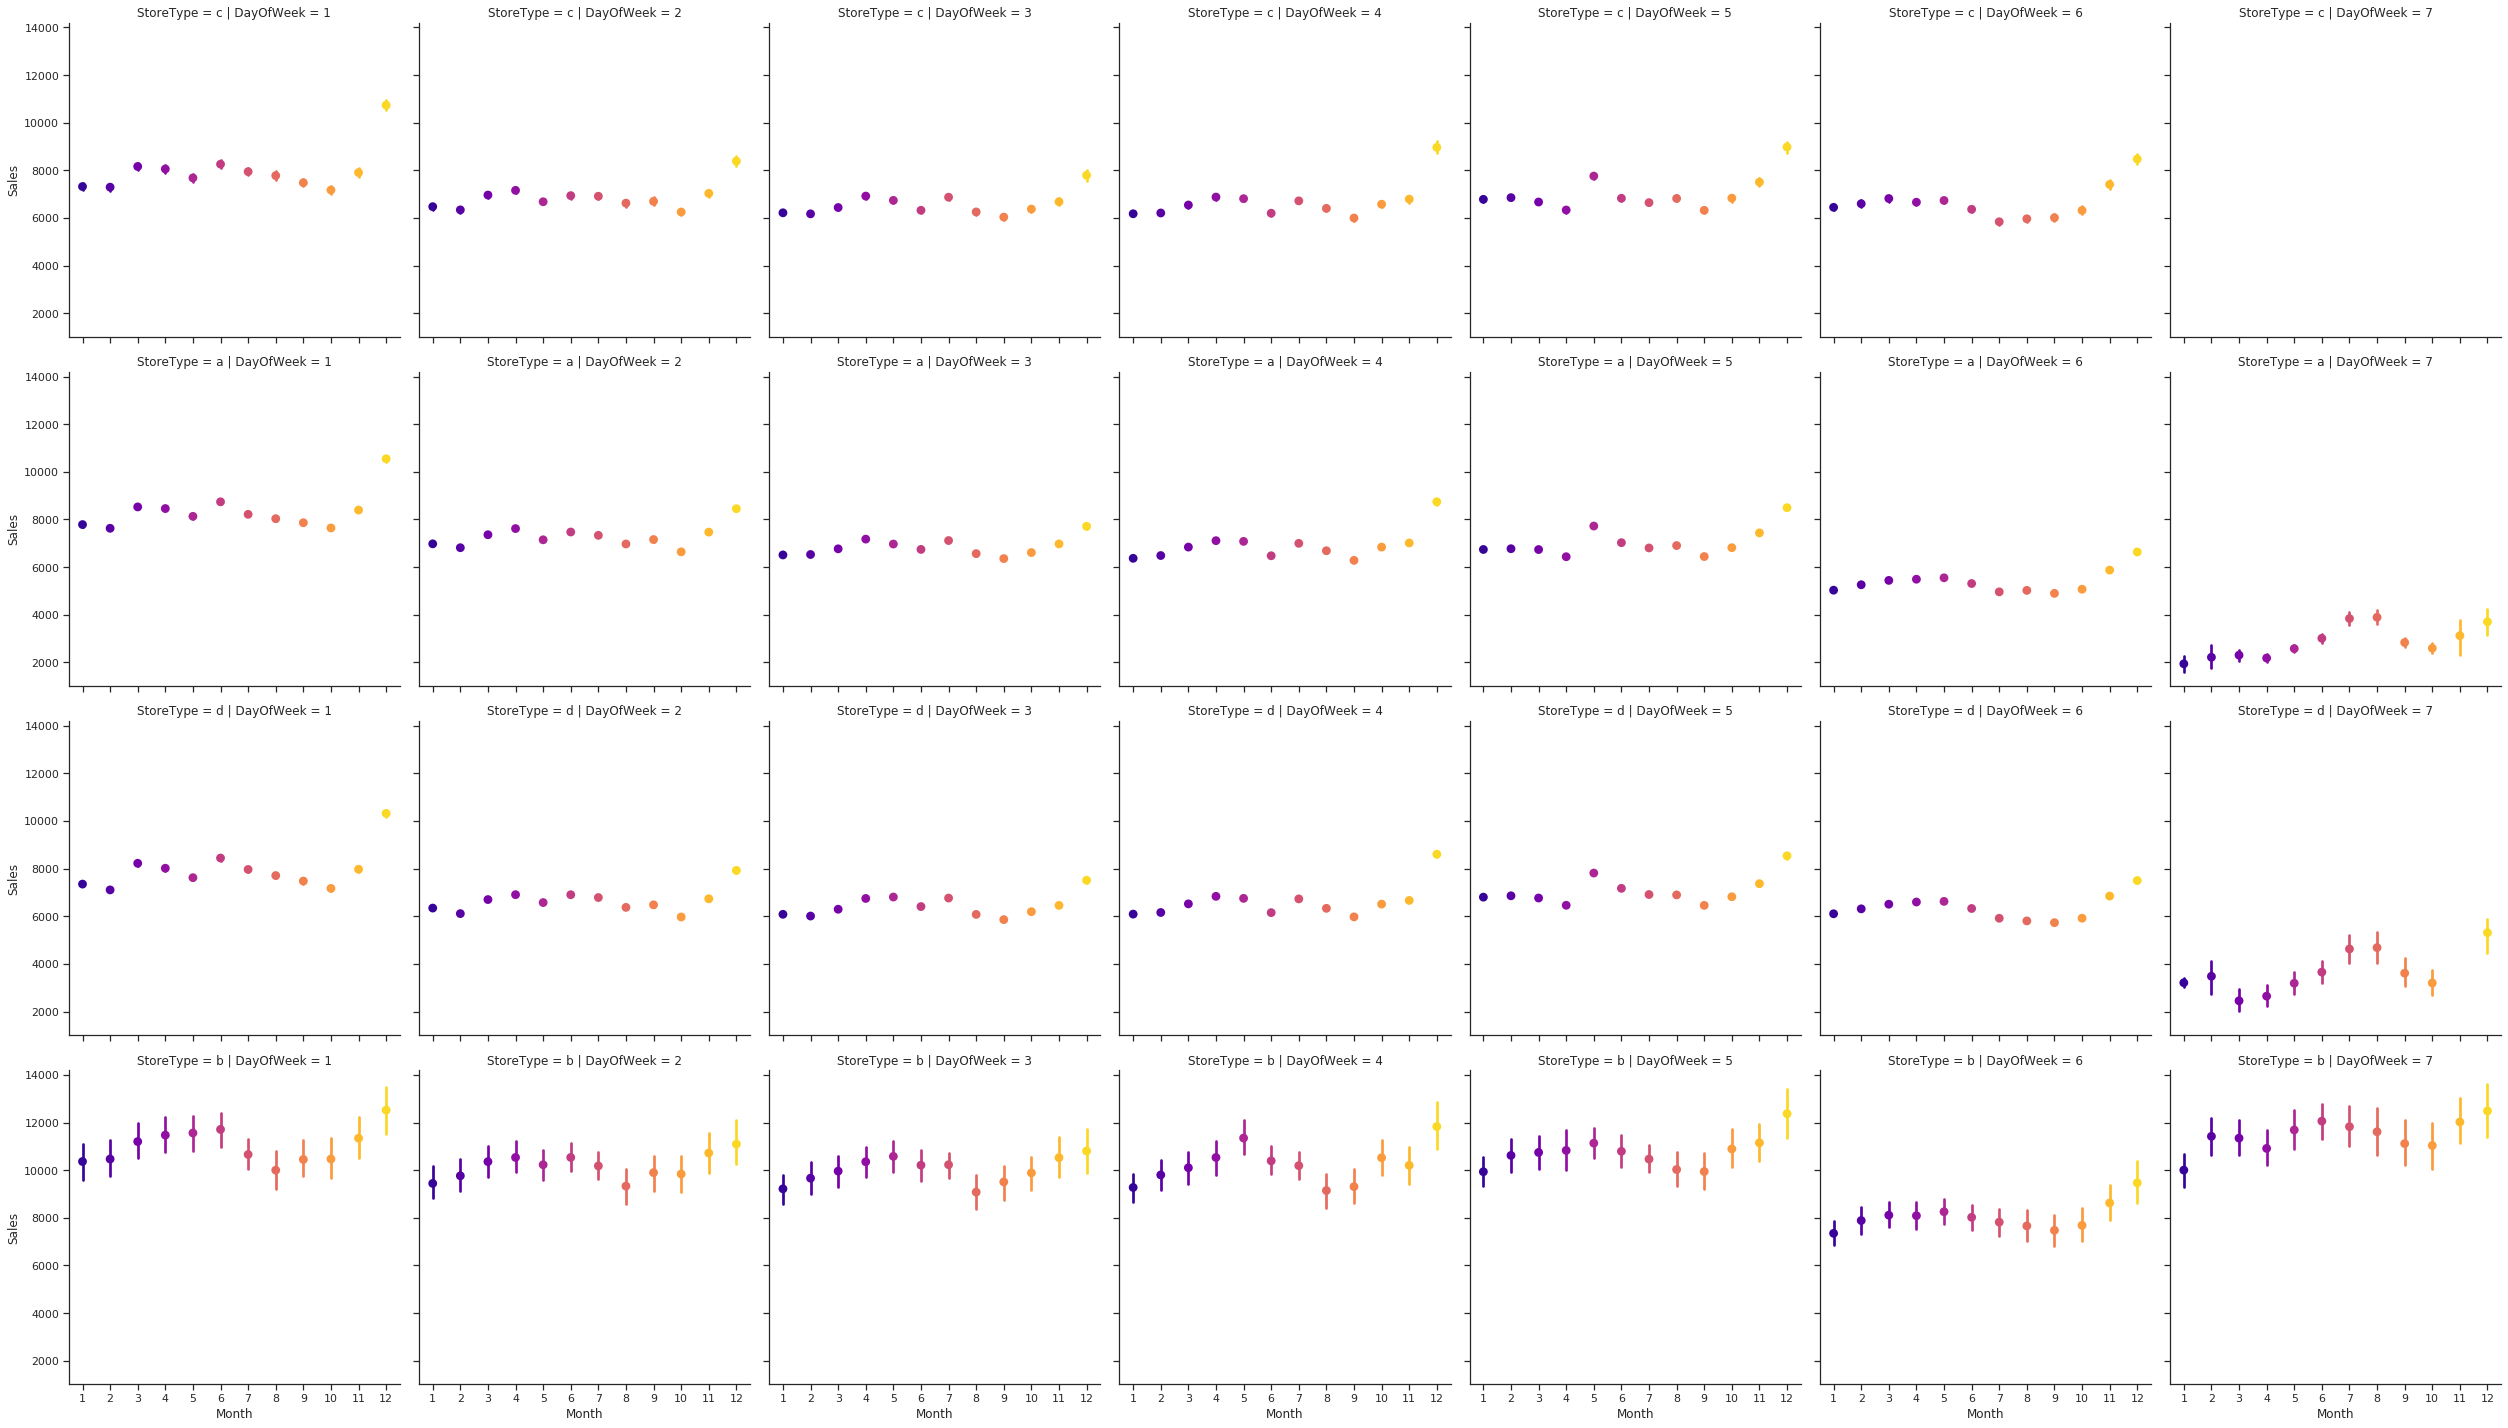

In [74]:
# Customers

sns.factorplot(data=train_store,x='Month',y='Sales',
               col='DayOfWeek',
               palette = 'plasma',
               row = 'StoreType',
               color = c)

We see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of StoreType D are closed on Sundays only from October to December.

what are the stores which are opend on sundays?

In [75]:
# stores which are opend on Sundays

train_store[(train_store.Open == 1)& (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

To complete our preliminary data analysis, we can add variables describing the period of time during which competition and promotion were opened:

In [76]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,10.958105,43.381276
b,10233.380141,2022.211825,3.717593,38.147815
c,6933.126425,815.538073,13.964386,45.339654
d,6822.300064,606.353935,14.827699,35.294751


The most selling and crowed StoreType A does'nt appear to be the one the most exposed to competitors. Insted it's a StoreType B which also has the longest running period of promotion.

#### Correlational Analysis

We are finished with adding new variables to the data, so now we can check the overall correlations by plotting the seaborn heatmap:

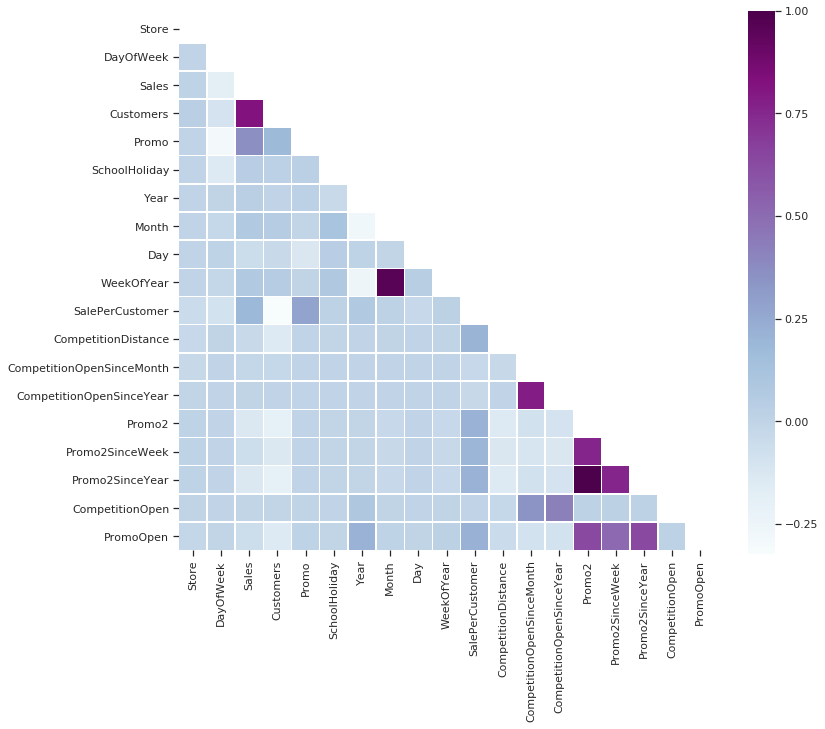

In [78]:
# Compute the correlation matrix
# exclude 'Open' variable

corr_all = train_store.drop('Open',axis=1).corr()

#Generate a mask for the upper triangle
mask = np.zeros_like(corr_all,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure

fig,ax = plt.subplots(figsize=(12,10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all,mask=mask,square = True,linewidths=.5,
            ax=ax,cmap='BuPu')
plt.show()

As mentioned before, we have a strong positive correlation between the amount of Sales and Customers of a store. We can also observe a positive correlation between the fact that the store had a running promotion(Promo equal to 1) and amount of Customers.

However, as soon as the store continues a consecutive promotion(Promo2 equal to 1) the number of Customers and Sales seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap. The same negative correlation is observed between the presence of the promotion in the store and the day of a week.

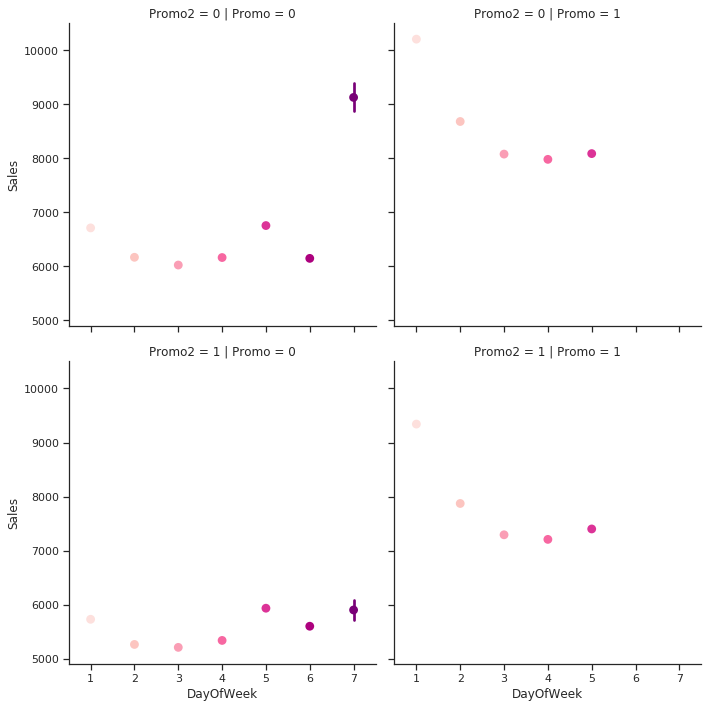

In [82]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               palette = 'RdPu') 

**There are several things here:**
* In case of no promotion, both Promo and Promo2 are equal to 0, Sales tend to peak on Sunday (!). Though we should note that StoreType C doesn't work on Sundays. So it is mainly data from StoreType A, B and D.<br>
* On the contrary, stores that run the promotion tend to make most of the Sales on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (Promo and Promo2 are equal to 1).<br>
* Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount. This can be also prooved by the blue pale area on the heatmap above.

#### Time-Series Analysis per Store Type

What makes a time series different from a regular regression proble?
* It is time dependent. The basic assumption of a linear regression that the observations are independent doesn't hold in this case.
* Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for Christmas holidays, which we will see in this dataset.
<br>

We build a time series analysis on store types insted of individual stores. The mail advantage of this approach is its simplicity of presentation and overall account for different trends an d seasonalities in the dataset.<br>

In this section, we will analyse time series data: its trends,sesonalities and autocorrelation. Usually at the end of the analysis, we are able to develope a seasonal ARIMA(Autoregression Integrated Moving Average) model but it won't be our main focus today. Insted, we try to understand the data, and only later come up with the forecats using Prophet methodology.

**Seasonality**
<br>
We take four stores from store types to represent their group:
* Store number 2 for StoreType A
* Store number 85 for StoreType B
* Store number 1 for StoreType C
* Store number 13 for StoreType D.
<br><br>
It also makes sense to downsample the data from days to weeks using resample method to see the present trends more clearly.

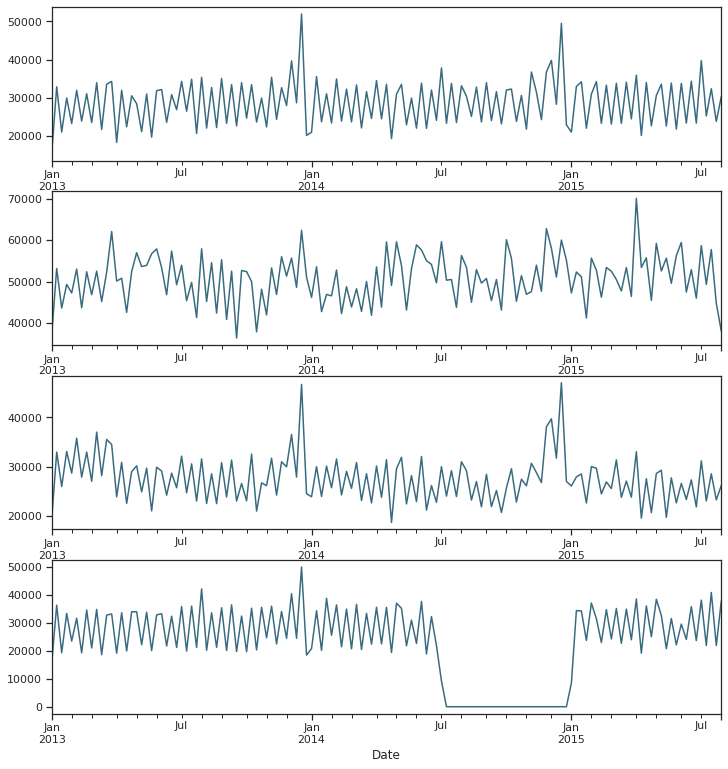

In [96]:
# preparation: input should be float type
train['Sales'] = train['Sales'] *1.0

# store types
sales_a = train[train.Store == 2]['Sales'].sort_index(ascending=True)
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending=True)    
sales_c = train[train.Store == 1]['Sales'].sort_index(ascending=True)
sales_d = train[train.Store == 13]['Sales'].sort_index(ascending=True)

fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,figsize=(12,13))

# store types

sales_a.resample('W').sum().plot(color=c, ax= ax1)
sales_b.resample('W').sum().plot(color=c, ax= ax2)
sales_c.resample('W').sum().plot(color=c, ax= ax3)
sales_d.resample('W').sum().plot(color=c, ax= ax4)

Retail sales for StoreType A and C tend to peak for the Christmas season and then decline after the holidays. We might have seen the same trend for Storetype D but there is no information from July 2014 to January 2015 about these stores as they were closed.<br>
**Monthly trend**
<br>

The next thing to check the presence of a trend in series.

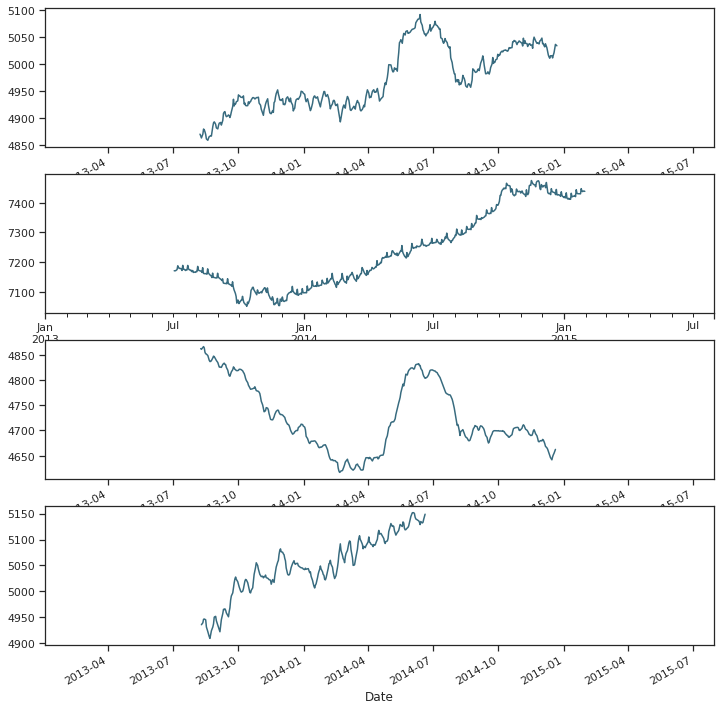

In [97]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)

Overall sales seems to increase, however not for the StoreType C. Eventhough the Storetype A is the most selling store type in the dataset, it seems that it cab follow the same decresing trajectory as StoreType C did.

**Autocorrelation**

The next step in ourtime series analysis is to review AutoCorrelation Function (ACF) and Partial Autocorrelation Function plots.
<br>
ACF is ameasure of the correlation beteen the timeseries with a lagged version of itself.
<br>
PACF on other hand, measures the correlaton between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons.

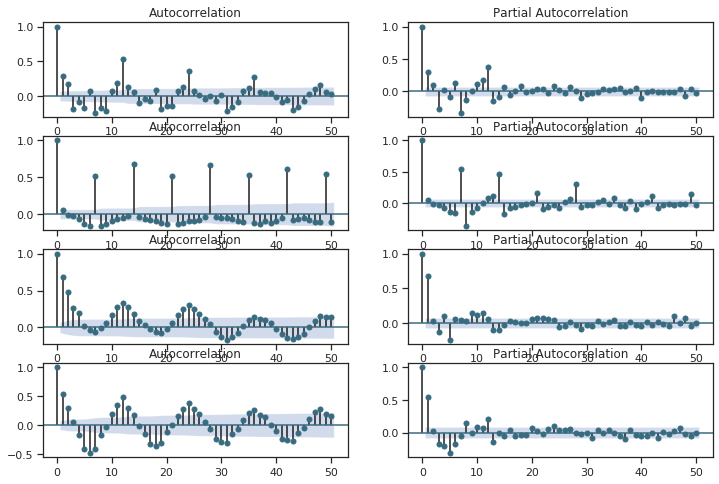

In [98]:
# figure for subplots
plt.figure(figsize=(12,8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.tight_layout()
plt.show()



We can read these plots horizontally. Each horizontal pair is for one 'StoreType', from A to D. in general, those plots are showing the correlation of the series with itself, lagged by x times units.

There is at two things common for each pair of plots :non rndomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).

* Type A and Tyep B: Both types show seasonalities at certain lags. For type A, it is each 12th observation with positives spikes at the 12(s) and 24(s) lags and so on. for type B its a weekly trend with positives spikes at the 7(s),14(2s),21(3s)and 28(4s) lags.

* Type C and type D: Plots of these two types are more complex. it seems like each observation is coorrelated to its adjacent abservations.

## Time Series Analysis and Forecastion with Prophet

**Forecasting for the next 6 weeks for the first store**
<br>
<br>
The Core Data Science team at Facebook recently published a new procedure for forecastion time series data called Prophet. it is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. it enables performing "automated forecasting which are already implemented in R" at scale in Python 3.


In [10]:
# importing data
df = pd.read_csv('/content/train.csv.zip',low_memory=False)

# remove closed stores and those with no sales
df = df[(df['Open'] != 0 ) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales  = df[df.Store == 1].loc[:,['Date','Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [12]:
# from the prophet documentation every variables should have specific name

sales  = sales.rename(columns= {'Date':'ds',
                                'Sales':'y' })
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


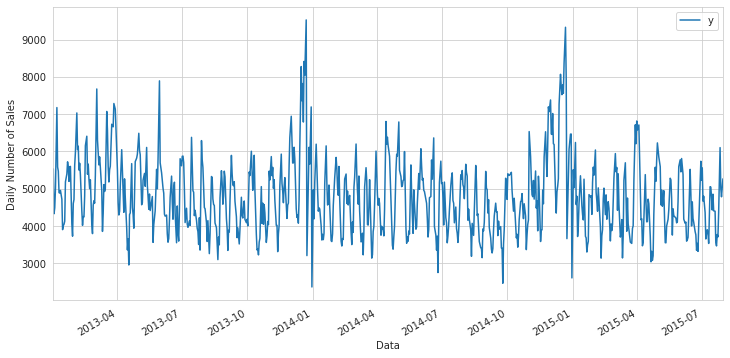

In [14]:
# plot daily sales

ax = sales.set_index('ds').plot(figsize=(12,6))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Data')
plt.show()

 **Modeling Holidays**
 <br>
 <br>
 Prophet also allows to model for holidays, and thats what we do here.
 <br>
 The StateHoliday variiable in the dataset indicates a state holiday, at which all stores are normally closed. There are also school holidays in the datasers at which certain stores are also closing their doors.

In [0]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a')|(df.StateHoliday == 'b') & 
                 (df.StateHoliday == 'c')].loc[:,'Date'].values

In [0]:
school_dates = df[df.SchoolHoliday == 1].loc[:,'Date'].values

In [0]:
state = pd.DataFrame({'holiday':'state_holiday',
                      'ds':pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                       'ds':pd.to_datetime(school_dates)})

In [0]:
holidays = pd.concat((state,school))

In [21]:
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [22]:
holidays

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04
...,...,...
163440,school_holiday,2013-01-01
163441,school_holiday,2013-01-01
163442,school_holiday,2013-01-01
163443,school_holiday,2013-01-01


In [24]:
# set the uncertainty interval to 95% (the prophet default is 80%)

my_model = Prophet(interval_width = 0.95,holidays=holidays)

my_model.fit(sales)

# dataframe that extends into future 6 weeks

future_dates = my_model.make_future_dataframe(periods=6*7)

print('First week to forecast.')
future_dates.tail(7)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [25]:
# predictions
forecast = my_model.predict(future_dates)

# predictions for last week
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4092.135712,2498.852620,5751.826171
817,2015-09-06,4087.032784,2502.478619,5760.006724
818,2015-09-07,4161.813517,2580.110669,5863.882235
819,2015-09-08,3664.142168,2079.183676,5353.959763
820,2015-09-09,3550.915165,1920.012239,5058.032418
821,2015-09-10,3462.435748,1942.771773,5007.532068
822,2015-09-11,3717.122489,2073.356006,5221.474024


The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [0]:
fc = forecast[['ds','yhat']].rename(columns={'Date':'ds',
                                             'Forecast':'yhat'})

Prophet plots the observed values of our time series (the black dots), the forecasted(blue line) and the uncertainty intervals of our forecasts(the blue shaded region).

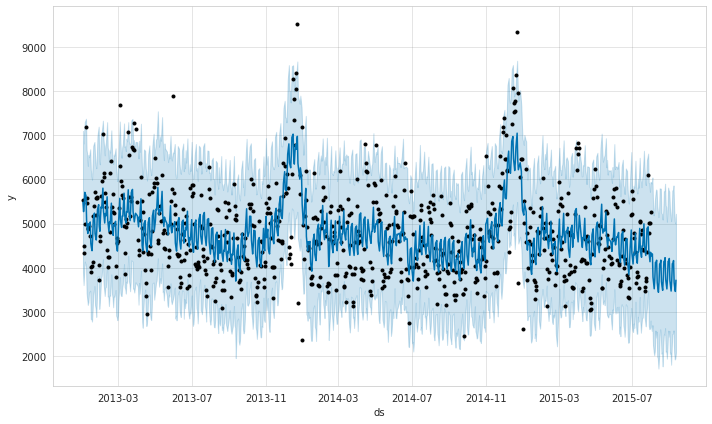

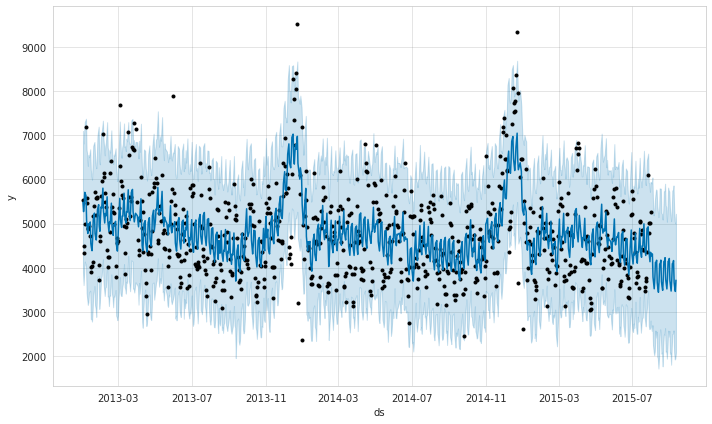

In [28]:
# visualizing prediction
my_model.plot(forecast)

As we see Prophet catches the trends and most of the time gets future values right.

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series plus manyally included holidayes contribute to the overall forecasted values:


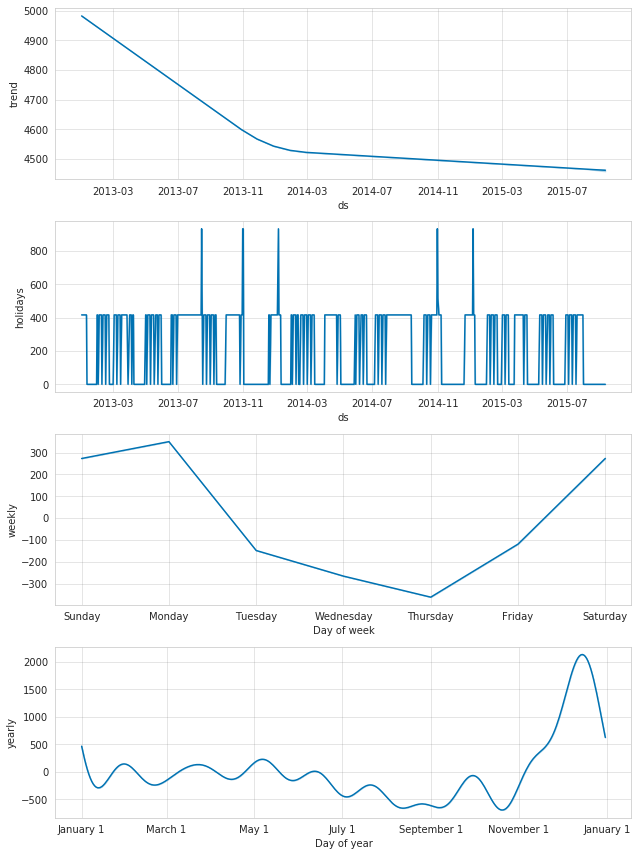

In [29]:
my_model.plot_components(forecast);

The first plot shows that the monthly sales of store number 1 has been linearly decreasing over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the most buzy season occurs during the Christmas holidays.


Conclusion of Time Series forecasting
During this part, we discussed time series analysis with .seasonal_decompose(), ACF and PCF plots and fitted forecasting model using a new procedure by Facebook Prophet.

We can now present main advantages and drawbacks of time series forecasting:
<br>
Advantages
<br>
* A powerful tool for the time series forecasting as it accounts for time dependencies, seasonalities and holidays (Prophet: manually).
* Easily implemented with R auto.arima() from forecast package, which runs a complex grid search and sophisticated algorithm behind the scene.<br>
Drawbacks
<br>
* Doesn't catch interactions between external features, which could improve the forecasting power of a model. In our case, these variables are Promo and CompetitionOpen.
* Even though Prophet offers an automated solution for ARIMA, this methodology is under development and not completely stable.
* Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the biggest drawback for new companies.
* Seasonal ARIMA in Python has 7 hyper parameters which can be tuned only manually affecting significantly the speed of the forecasting process.
